In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
import os
from sklearn.utils.class_weight import compute_class_weight
import pickle
import importlib

# define class list
class_list = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

# Target no samples per class with AUgmentation
TARGET_NUMSAMPLES_PER_CLASS = 5784

# target_size
TARGET_SIZE = (192,256)

BATCH_SIZE = 32
RANDOM_SEED = 42


In [1]:
# mount google drive where preprocessed images are
# Mount drive and download data from EDA step 1
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# create directory in virtual environment
# this takes about 3 mins, please be patient
VDIR_PROJECT = '/content/skin_cancer/training'
os.makedirs(VDIR_PROJECT, exist_ok=True)

# define source directory from Gdrive
GDIR_PROJECT_EDA_S1 = '/content/drive/MyDrive/AAI-521/Module7/TeamProject/EDA_PrePro/S1'

# Copy S1 onto virtual env
!cp -r {GDIR_PROJECT_EDA_S1}/* {VDIR_PROJECT}

# clone repo on virtual directory.
# for now copy files needed

In [4]:
# variables for val and train directories in virtual env
VDIR_PROJECT_VAL = VDIR_PROJECT + '/val'
VDIR_PROJECT_TRAIN = VDIR_PROJECT + '/train'


In [7]:
# check number of train images per class
print(f"Current Train Dir: {VDIR_PROJECT_TRAIN}")
for idx, dx_type in enumerate(class_list):
  print(dx_type, len(os.listdir(VDIR_PROJECT_TRAIN+'/'+dx_type)))

Current Train Dir: /content/skin_cancer/training/train
akiec 297
bcc 479
bkl 1003
df 107
mel 1065
nv 5784
vasc 129


In [5]:
# function that generates augmented images in target dir (on colab, make sure target_dir is on virtual env)
def generate_augmented_images(source_dir, target_dir, target_count, target_class, target_size=(256,256), batch_size = 256):

  # source_dir: basis of generation of augmented images, must contain subdirectories with different classes
  # target_dir: where all augmented images and base images are saved, a subdirectory will be created for the specified target_class
  #
  # target_count: required number of images per target_class
  # target_class: Image Data Generator will only consider images from the specified target_class

  # uses global BATCH_SIZE and TARGET_SIZE variables
  print("\tTARGET_CLASS: ", target_class)
  # initialize image data generator
  # many of the the configuratios below are from (1)
  datagen = ImageDataGenerator(
    rotation_range = 180, # as per (1)
    width_shift_range=0.15, # as per (1)
    height_shift_range=0.15, # as per (1)
    zoom_range=0.1, # arbitrarily chosen
    shear_range=0.15, # (1)
    horizontal_flip=True, #(1)
    vertical_flip=True, #(1)
    brightness_range=(0.9,1.5), #(1)
    fill_mode='nearest') # keras default

  print("\tSOURCE DIR: ", source_dir)

  print("\tTARGET_COUNT: ", target_count)

  # create target directory for this class
  target_dir = os.path.join(target_dir, target_class)
  os.makedirs(target_dir, exist_ok=True)
  print("\tTARGET DIR: ", target_dir)

  # apply image data generator above on source_dir
  aug_generator = datagen.flow_from_directory(
    source_dir,
    seed=42,
    save_to_dir=target_dir,
    save_format='jpg',
    target_size=target_size,
    batch_size=batch_size,
    classes=[target_class])

  # count number of batches needed to generate augmented images for this class
  num_base_images = len(os.listdir(source_dir+'/'+target_class))
  print("\tNUM BASE IMAGES: ", num_base_images)

  num_aug_images_wanted = target_count - num_base_images
  if(num_aug_images_wanted < 0): num_aug_images_wanted = 0
  print("\tNUM AUG IMAGES NEEDED: ", num_aug_images_wanted)

  num_batches = int(np.ceil(num_aug_images_wanted / batch_size))
  print("\tNUM BATCHES2: ", num_batches)

  # call generator enough number of times to generate/save desired number of images
  for i in range(0, num_batches):
    #print(f"i:{i}", end='/r')
    print(f"\tBatch No: {i}", flush=True)
    #time.sleep(1.0)
    next(aug_generator)

  return

In [11]:
# generate augmented images so there is around the same number of images per class
# apply above function on each class in train
source_dir = VDIR_PROJECT_TRAIN
target_dir = VDIR_PROJECT_TRAIN

# define class list
class_list = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

for idx, dx_type in enumerate(class_list):
  print(f"dx_type: {dx_type}")
  generate_augmented_images(source_dir, target_dir, target_count = TARGET_NUMSAMPLES_PER_CLASS, target_class = dx_type, target_size=TARGET_SIZE, batch_size=256)

dx_type: akiec
	TARGET_CLASS:  akiec
	SOURCE DIR:  /content/skin_cancer/training/train
	TARGET_COUNT:  5784
	TARGET DIR:  /content/skin_cancer/training/train/akiec
Found 297 images belonging to 1 classes.
	NUM BASE IMAGES:  297
	NUM AUG IMAGES NEEDED:  5487
	NUM BATCHES2:  22
	Batch No: 0
	Batch No: 1
	Batch No: 2
	Batch No: 3
	Batch No: 4
	Batch No: 5
	Batch No: 6
	Batch No: 7
	Batch No: 8
	Batch No: 9
	Batch No: 10
	Batch No: 11
	Batch No: 12
	Batch No: 13
	Batch No: 14
	Batch No: 15
	Batch No: 16
	Batch No: 17
	Batch No: 18
	Batch No: 19
	Batch No: 20
	Batch No: 21
dx_type: bcc
	TARGET_CLASS:  bcc
	SOURCE DIR:  /content/skin_cancer/training/train
	TARGET_COUNT:  5784
	TARGET DIR:  /content/skin_cancer/training/train/bcc
Found 479 images belonging to 1 classes.
	NUM BASE IMAGES:  479
	NUM AUG IMAGES NEEDED:  5305
	NUM BATCHES2:  21
	Batch No: 0
	Batch No: 1
	Batch No: 2
	Batch No: 3
	Batch No: 4
	Batch No: 5
	Batch No: 6
	Batch No: 7
	Batch No: 8
	Batch No: 9
	Batch No: 10
	Batch No:

In [14]:
# check number of train images per class
print(f"Current Train Dir: {VDIR_PROJECT_TRAIN}")
for idx, dx_type in enumerate(class_list):
  print(dx_type, len(os.listdir(VDIR_PROJECT_TRAIN+'/'+dx_type)))

Current Train Dir: /content/skin_cancer/training/train
akiec 3564
bcc 5525
bkl 5783
df 2568
mel 5284
nv 5784
vasc 3096


In [13]:
# make sure these are consistent with the preprocessing operation

# create image iterators
datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values

# create train dataset generator
train_generator = datagen.flow_from_directory(
    VDIR_PROJECT_TRAIN,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode = 'categorical',
    seed = RANDOM_SEED)


# create validation dataset generator
val_generator = datagen.flow_from_directory(
    VDIR_PROJECT_VAL,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode = 'categorical',
    seed = RANDOM_SEED)



Found 31604 images belonging to 7 classes.
Found 1094 images belonging to 7 classes.


In [15]:
# Compute class weights
classes = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weight_dict = dict(enumerate(class_weights))
class_weight_dict



{0: 1.2667949334616002,
 1: 0.8171687136393019,
 2: 0.7807119389343149,
 3: 1.758121940364931,
 4: 0.8544392776035471,
 5: 0.7805769610748864,
 6: 1.4582871908453303}

In [16]:
# create base classifier model
# Load the DenseNet model with pre-trained weights from ImageNet
input_shape = (TARGET_SIZE[0],TARGET_SIZE[1], 3)
print("input_shape = ", input_shape)
base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
base_model.trainable = False

# Create a new model on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  # Use 'softmax' for multi-class classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])

input_shape =  (192, 256, 3)
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
# print summary
base_model.summary()
model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 192, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 198, 262, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 96, 128, 64)    │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 96, 128, 64)    │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 96, 128, 64)    │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 98, 130, 64)    │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 48, 64, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 48, 64, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 48, 64, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 48, 64, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 48, 64, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 48, 64, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 48, 64, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 48, 64, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 6, 8, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,565,895 (28.86 MB)

 Trainable params: 528,391 (2.02 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [19]:
# train model
history = model.fit(
    train_generator,
    #steps_per_epoch=len(train_generator),
    class_weight=class_weight_dict,
    validation_data=val_generator,
    #validation_steps=len(val_generator),
    epochs=40, verbose=1)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


988/988 ━━━━━━━━━━━━━━━━━━━━ 96s 70ms/step - categorical_accuracy: 0.4980 - loss: 1.3003 - val_categorical_accuracy: 0.8318 - val_loss: 0.4770
Epoch 2/40
988/988 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - categorical_accuracy: 0.6096 - loss: 0.9684 - val_categorical_accuracy: 0.8382 - val_loss: 0.4722
Epoch 3/40
988/988 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - categorical_accuracy: 0.6373 - loss: 0.8995 - val_categorical_accuracy: 0.8464 - val_loss: 0.4388
Epoch 4/40
988/988 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - categorical_accuracy: 0.6503 - loss: 0.8581 - val_categorical_accuracy: 0.8519 - val_loss: 0.4355
Epoch 5/40
988/988 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - categorical_accuracy: 0.6701 - loss: 0.8080 - val_categorical_accuracy: 0.8519 - val_loss: 0.4517
Epoch 6/40
988/988 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - categorical_accuracy: 0.6794 - loss: 0.7808 - val_categorical_accuracy: 0.8583 - val_loss: 0.4150
Epoch 7/40
988/988 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - categorical_accuracy: 0.6926 - 

In [18]:
# define a function that saves the model weights, training history in the virtual environment
def save_model(TARGET_DIR, model_name="default", model=[], history=[]):
  # check if model exists already to avoid overwriting previous ones
  model_path = TARGET_DIR + '/'+model_name
  if os.path.exists(model_path) and os.path.isdir(model_path):
    print("Folder exists, exiting")
    return
  else:
    print(f"Saving model and training history in :{model_path}")
    os.makedirs(model_path, exist_ok=True)

  model.save(model_path+'/model.keras')
  with open(model_path+'/training_history.pkl', 'wb') as file:
    pickle.dump(history, file)

  return


In [20]:
VDIR_PROJECT_MODELS = VDIR_PROJECT+'/models'
save_model(VDIR_PROJECT_MODELS, "base+aug", model, history)

Saving model and training history in :/content/skin_cancer/training/models/base+aug


In [21]:
# Save model to GDRIVE
GDIR_PROJECT_TRAINING = '/content/drive/MyDrive/AAI-521/Module7/TeamProject/Training/'
os.makedirs(GDIR_PROJECT_TRAINING, exist_ok=True)

In [22]:
# copy training results from virtual to gdrive
!cp -r {VDIR_PROJECT_MODELS} {GDIR_PROJECT_TRAINING}

In [23]:
# copy evaluation_functions.py from gdrive to current working directory
GDIR_PROJECT_COMMON_FUNCTIONS = '/content/drive/MyDrive/AAI-521/Module7/TeamProject/Common_Functions'

!cp -r {GDIR_PROJECT_COMMON_FUNCTIONS}/* ./

In [24]:
import evaluation_functions as ef
importlib.reload(ef)

<module 'evaluation_functions' from '/content/evaluation_functions.py'>

Available Metrics1: ['categorical_accuracy', 'loss']

Here1: metrics: ['categorical_accuracy' 'loss']

Metrics to display: ['categorical_accuracy' 'loss']

Num Rows:  1
plotA 0 train/val curves for metric categorical_accuracy

plotA 1 train/val curves for metric loss



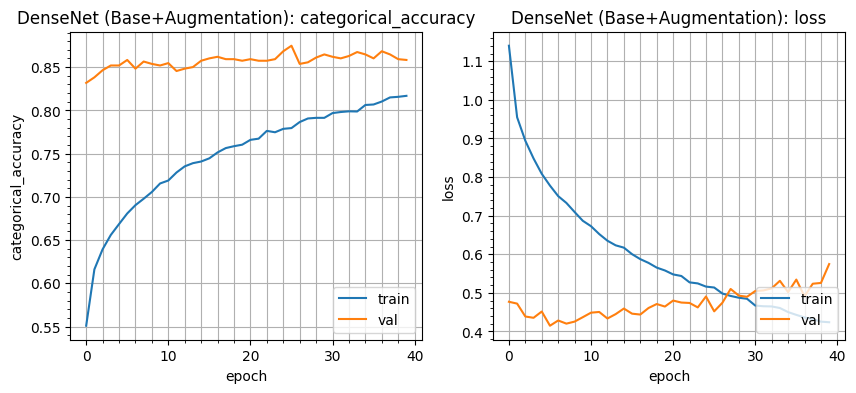

Found 1094 files belonging to 7 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step
              precision    recall  f1-score   support

       akiec       0.47      0.27      0.34        30
         bcc       0.59      0.49      0.53        35
         bkl       0.54      0.58      0.56        86
          df       0.31      0.50      0.38         8
         mel       0.33      0.28      0.30        46
          nv       0.94      0.96      0.95       876
        vasc       0.79      0.85      0.81        13

    accuracy                           0.86      1094
   macro avg       0.57      0.56      0.55      1094
weighted avg       0.85      0.86      0.86      1094



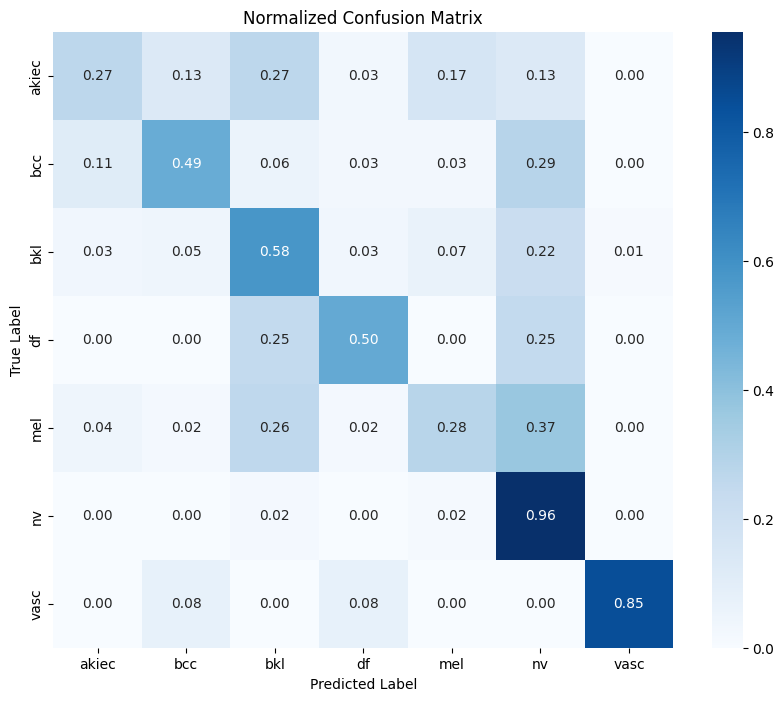

In [26]:
ef.group5_evaluate(VDIR_PROJECT_VAL, model=model, model_name="DenseNet (Base+Augmentation)",class_list =class_list,
                   training_history = history, batch_size=256, image_size = (192,256))